# Play with k8s cluster using python

- __Installation__
  * pip
  * kubernetes
  * pandas (Only needed for cluster data analysis)
  * k8sclient (wrapper for kubernetes)


- __Collect cluster information and data analysis with pandas__
  * setup
  * pod
  * node
  * service
  * etc.
 
  
- __Deploy pod/replicaset/service and some simple usage/test__
  * pods, volume, service and etc.
  * replicaset
  * network connectivity test
  * file system test (fio), network throughput (iperf), pod stress test and etc
  * service search
  * query api (hubot)

## Installation
#### [pip](https://pip.pypa.io/en/stable/installing/)
>Be cautious if you're using a Python install that's managed by your operating system or another package manager. get-pip.py does not coordinate with those tools, and may leave your system in an inconsistent state.
>To install pip via package manager, use package name python-pip
>Python3 is recommented though, not sure thoes numpy/pandas package can work well with python3

```shell
wget https://bootstrap.pypa.io/get-pip.py
python get-pip.py
```

#### [kubernetes](https://github.com/kubernetes-incubator/client-python/)
```shell
pip install kubernetes
```
> Usefully documentation links 
   * [auto generated docs](https://github.com/kubernetes-incubator/client-python/blob/master/kubernetes/README.md)
   * [api references](https://kubernetes.io/docs/api-reference/v1.6/)


#### [pandas](pandas.pydata.org/pandas-docs/stable/)
```shell
pip install pandas
```

#### k8sclient
```shell
git clone ssh://git@10.19.248.200:30884/DavidWang/k8sft.git
cd k8sft && pip install -e .
```

## Collect cluster information

### notebook setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from k8sclient.keywords import switch_cluster, register_cluster
# register_cluster("yancheng", "~/.kube/config-yancheng")
register_cluster("shanghai-console", "~/.kube/config-shanghai-console")
# switch_cluster("yancheng")
switch_cluster("shanghai-console")

### Pod information

#### collect all pods information

In [7]:
from k8sclient.dataframes import collect_namespaced_pods
dfs = collect_namespaced_pods("monkey")
# dfs['pod']

ApiException: (403)
Reason: 
HTTP response headers: HTTPHeaderDict({'Transfer-Encoding': 'chunked', 'Date': 'Thu, 21 Sep 2017 06:30:39 GMT', 'Content-Type': 'application/json', 'X-Application-Context': 'application:prod:8809'})
HTTP response body: {"code":8090002,"message":"the user has no permission to access the resources","payload":{}}


In [3]:
from k8sclient.dataframes import collect_all_pods
pods = collect_all_pods()

ApiException: (403)
Reason: 
HTTP response headers: HTTPHeaderDict({'Transfer-Encoding': 'chunked', 'Date': 'Thu, 21 Sep 2017 06:28:32 GMT', 'Content-Type': 'application/json', 'X-Application-Context': 'application:prod:8809'})
HTTP response body: {"code":8090002,"message":"the user has no permission to access the resources","payload":{}}


In [8]:
pods['container'].columns

Index([u'args', u'command', u'image', u'image_pull_policy', u'lcpu',
       u'lmemory', u'name', u'pod_id', u'rcpu', u'ready', u'restart_count',
       u'rmemory', u'state'],
      dtype='object')

#### list abnormal pods

In [5]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
bads = container[((container['state'] != 'running') | (container['phase'] != 'Running'))]
bb = bads[['namespace', 'pod', 'phase', 'state', 'host_ip', 'rmemory', 'rcpu', 'stime']].dropna()
# bb[bb.phase == 'Running']
c = bads.groupby(['namespace', "phase"]).size().reset_index().set_index(["namespace","phase"])
c.columns = ['count']
c

count
namespace            phase           
ary                  Pending        1
                     Running        4
cc-demo              Pending        3
cc-dev               Pending        1
cc-qa-test           Pending        3
cc-wjx-local         Pending        1
hadoop               Pending        2
health-check         Pending        4
impala-dq            Pending        1
lbsheng              Succeeded      1
monitor-system-alert Running        2
streaming-demo       Running        2
yancheng-jsonnet     Pending        3
yiren                Running        5
zhuangwei            Pending        2

In [ ]:
pods['pod'].columns
# container[container.command.str.contains("exe")]

#### list pod count using host-path

In [52]:
v = pods['volume']
hp = v[v.vtype == "host_path"].dropna(axis=1)
hpp = pd.merge(pods['pod'], hp, left_on="uid", right_on="pod_id")
hpp[["name", "path", "host_ip", "namespace", "pod"]].groupby("namespace").size().reset_index().set_index("namespace")

,0
namespace,
4tools,2
ceph,118
ceph-dq,117
gaming,1
hadoop-dengquan,5
hadoop-dq,10
hadoop-tdd,8
haproxy,1
he2chat,1


In [22]:
v = pods['volume']
tv = pd.merge(pods['pod'], v, left_on="uid", right_on="pod_id")
t = tv[["namespace", "pod", 'name', 'path', "host_ip"]].dropna()
tt = t[t.path.str.contains("kubernetes")]
tt[tt.host_ip == "10.19.248.18"]

,namespace,pod,name,path,host_ip
966,kube-system,haproxy-10.19.248.18,pem,/etc/kubernetes/ca_file/node/client.pem,10.19.248.18
976,kube-system,kube-lego-4026317241-w3mkf,kubeconfig,/etc/kubernetes/node-kubeconfig,10.19.248.18
995,kube-system,kube-proxy-10.19.248.18,logfile,/var/log/kubernetes/kube-proxy,10.19.248.18
996,kube-system,kube-proxy-10.19.248.18,certificate,/etc/kubernetes/,10.19.248.18


In [53]:
hpp[hpp.namespace=="jingwuyun"]

,cluster_name,ctime,dns_policy,host_ip,host_ipc,host_network,host_pid,namespace,node_name,phase,pod,pod_ip,restart_policy,stime,uid,name,path,pod_id,vtype
263,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-alpine-git-260601664-6fflf,172.16.121.29,Always,2017-07-28 07:01:18+00:00,8d5d5651-7362-11e7-a0f0-244427a00052,docker-socket,/var/run/docker.sock,8d5d5651-7362-11e7-a0f0-244427a00052,host_path
264,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-alpine-git-260601664-6fflf,172.16.121.29,Always,2017-07-28 07:01:18+00:00,8d5d5651-7362-11e7-a0f0-244427a00052,kubeconfig,/etc/kubernetes/node-kubeconfig,8d5d5651-7362-11e7-a0f0-244427a00052,host_path
265,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-jwy-358576113-c5vd2,172.16.121.31,Always,2017-07-28 07:01:18+00:00,8d80e8c8-7362-11e7-a0f0-244427a00052,docker-socket,/var/run/docker.sock,8d80e8c8-7362-11e7-a0f0-244427a00052,host_path
266,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-jwy-358576113-c5vd2,172.16.121.31,Always,2017-07-28 07:01:18+00:00,8d80e8c8-7362-11e7-a0f0-244427a00052,kubeconfig,/etc/kubernetes/node-kubeconfig,8d80e8c8-7362-11e7-a0f0-244427a00052,host_path


#### found 0 limit pods

In [6]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
bads = runnings[(runnings.lmemory == 0) | (runnings.lcpu == 0)]
pd.DataFrame({"#pods without memory/cpu limit": bads.groupby("namespace").size()})

,#pods without memory/cpu limit
namespace,
cc-demo,1
cc-dev,1
cc-itg,1
cc-stage,1
ccc-hadoop0,17
dataflow-demo-ye,4
liye-test-sh,5
monitor-essential-service,9
ping,14


#### cpu request too much

In [8]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
# runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
runnings = container[(container['state'] == 'running')]
bads = runnings[(runnings.rcpu > 1) ]
bads[['namespace', "pod", 'rcpu', 'rmemory']].sort_values(by="rcpu", ascending=False)

,namespace,pod,rcpu,rmemory
517,yechunan,orientdb-313092577-nl34c,2.0,2.000000
35,cc-dev,cc-template-194725396-hmr4z,1.3,1.855469


#### simple plot

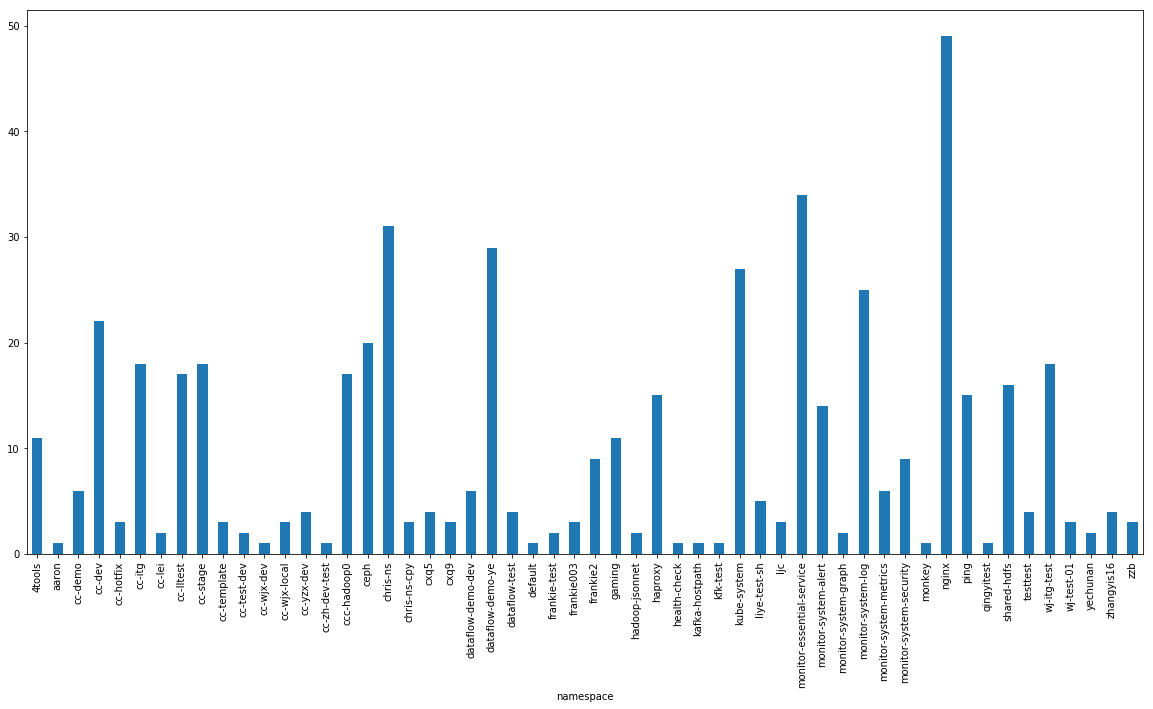

In [9]:
bins = pods['pod'].groupby(['namespace']).size()
bins.plot(kind="bar", figsize=(20,10))


#### plot node resource request percentage

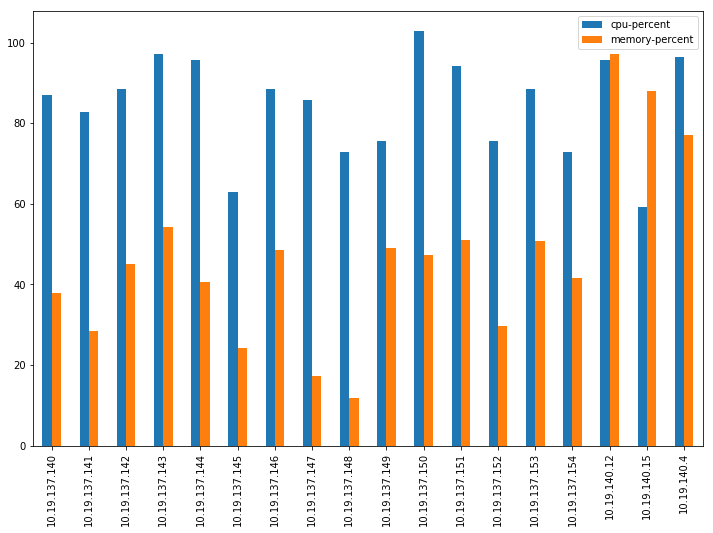

In [3]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
# runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
runnings = container[(container['phase'] == 'Running')]
res = runnings[["host_ip", "rcpu", "rmemory",]]# "lcpu", "lmemory", "pod"]]
# res.groupby('host_ip').sum().plot(kind='bar')
# percentage
a = res.groupby('host_ip').sum()
from k8sclient.dataframes import collect_nodes
nodes = collect_nodes().set_index("name")[["a-cpu", "a-memory"]]
b = pd.concat([a, nodes], axis=1)
b["cpu-percent"] = b['rcpu']*100/b['a-cpu']
b["memory-percent"] = b['rmemory']*100/b['a-memory']
b[['cpu-percent', "memory-percent"]].plot(kind='bar', figsize=(12,8))

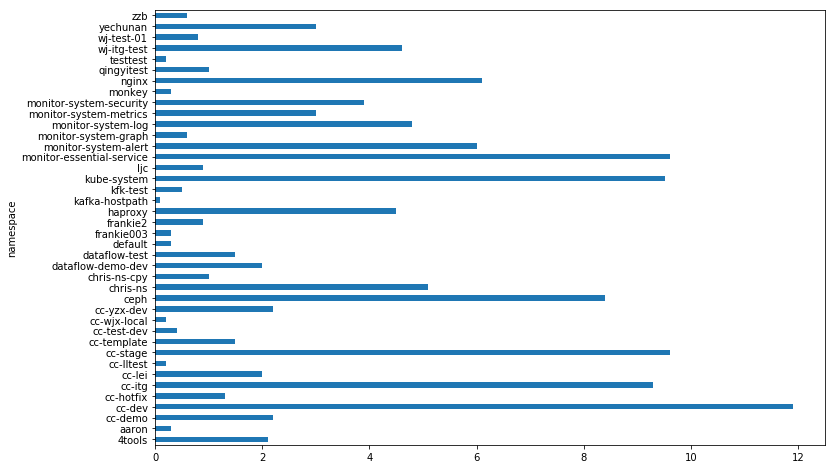

In [22]:
res_namespace = runnings[["namespace", "rcpu", "rmemory",]]
b = res_namespace.groupby('namespace').sum()
b[b.rcpu > 0]['rcpu'].plot(kind='barh', figsize=(12,8))

#### find memory request -ill configured pods

In [11]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
bads = runnings[(runnings.rmemory > 64) | (runnings.lmemory > 64)]
bads[['namespace', "pod", 'rmemory']]

,namespace,pod,rmemory


#### plot running pod per node

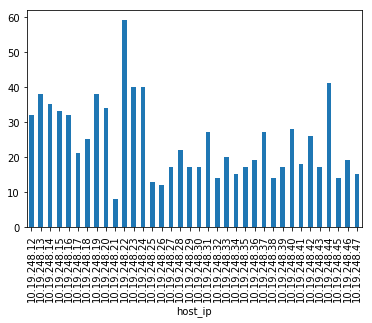

In [31]:
p = pods['pod']
runnings = p[p['phase'] == 'Running']
runnings.groupby('host_ip').size().plot(kind='bar')

#### plot running containers per node

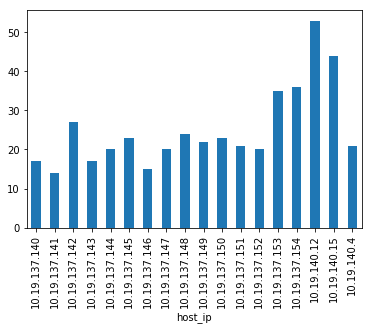

In [13]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
runnings.groupby('host_ip').size().plot(kind='bar')

#### read pod logs

In [ ]:
from k8sclient.keywords import tail_pod_logs
r = tail_pod_logs("monitor-essential-service", "elasticsearch-data-734v4", lines=20)
# r.strip().split("\n")
print r

### Node information

In [14]:
from k8sclient.dataframes import collect_nodes
nodes = collect_nodes()
# nodes[["name","a-cpu", "a-memory", "a-pods", "c-cpu", "c-memory", "purpose", "role"]].set_index("name")

In [15]:
nodes[nodes.name=='10.19.248.43'].T

""
DiskPressure
MemoryPressure
OutOfDisk
Ready
a-cpu
a-memory
a-pods
addition
beta.kubernetes.io/arch
beta.kubernetes.io/os


In [16]:
n = nodes.set_index("name")
n[n.nvidiagpu > 0][["a-cpu", "a-memory", "a-pods", "addition", "nvidiagpu"]]

,a-cpu,a-memory,a-pods,addition,nvidiagpu
name,,,,,
10.19.137.147,7.0,60.596355,600,GPU,2
10.19.137.148,7.0,60.596340,600,GPU,2
10.19.137.149,7.0,60.596359,600,GPU,2
10.19.137.150,7.0,60.596359,600,GPU,2
10.19.137.151,7.0,60.596268,600,GPU,2


### Service information

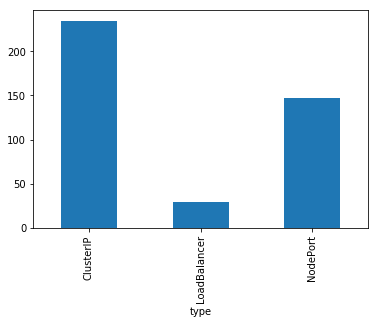

In [17]:
%matplotlib inline
from k8sclient.dataframes import collect_services
services, ports, eips = collect_services()
services.groupby("type").size().plot(kind="bar")

#### check conflict external ip ports

In [18]:
import pandas as pd
external_ports = pd.merge(ports, eips)
a = pd.merge(services, external_ports, left_on="uid", right_on="service_id")
b = a[['namespace', "name_x", "type", "port", "target_port", "external_ip"]]
c = b[["external_ip", "port"]].duplicated(keep=False)
b[c].set_index(["external_ip","port"]).sort_index()

namespace              name_x       type  \
external_ip   port                                                              
10.19.137.140 22181                      aaron  pre1-zookeeper1-ex  ClusterIP   
              22181                ccc-hadoop0  demo-zookeeper1-ex  ClusterIP   
              22181          dataflow-demo-dev  pre1-zookeeper1-ex  ClusterIP   
              22181                   dataflow  pre1-zookeeper1-ex  ClusterIP   
              22181               liye-test-sh  pre1-zookeeper1-ex  ClusterIP   
              22181  monitor-essential-service  pre1-zookeeper1-ex  ClusterIP   
              8180            dataflow-demo-ye          kafka2hdfs  ClusterIP   
              8180                        ping          kafka2hdfs  ClusterIP   
              8181            dataflow-demo-ye          kafka2hdfs  ClusterIP   
              8181                        ping          kafka2hdfs  ClusterIP   
10.19.137.141 22181                      aaron  pre1-zookeeper2-ex  ClusterIP   
              22181                ccc-hadoop0  demo-zookeeper2-ex  ClusterIP   
              22181          dataflow-demo-dev  pre1-zookeeper2-ex  ClusterIP   
              22181                   dataflow  pre1-zookeeper2-ex  ClusterIP   
              22181               liye-test-sh  pre1-zookeeper2-ex  ClusterIP   
              22181  monitor-essential-service  pre1-zookeeper2-ex  ClusterIP   
10.19.137.142 22181                      aaron  pre1-zookeeper3-ex  ClusterIP   
              22181                ccc-hadoop0  demo-zookeeper3-ex  ClusterIP   
              22181          dataflow-demo-dev  pre1-zookeeper3-ex  ClusterIP   
              22181                   dataflow  pre1-zookeeper3-ex  ClusterIP   
              22181               liye-test-sh  pre1-zookeeper3-ex  ClusterIP   
              22181  monitor-essential-service  pre1-zookeeper3-ex  ClusterIP   

                    target_port  
external_ip   port               
10.19.137.140 22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              8180         8180  
              8180         8180  
              8181         8181  
              8181         8181  
10.19.137.141 22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
10.19.137.142 22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              22181        2181  
              22181        2181

#### check conflict Nodeport ports

In [19]:
import pandas as pd
a = pd.merge(services, ports, left_on="uid", right_on="service_id")
b = a[['namespace', "name_x", "type", "node_port", "target_port"]]
c = b["node_port"].duplicated(keep=False) & (b.node_port != "None")
b[c].set_index(["node_port"]).sort_index()

,namespace,name_x,type,target_port
node_port,,,,


#### check conflict between nodeport and external ip ports

In [20]:
import pandas as pd
external_ports = pd.merge(ports, eips)
a = pd.merge(services, ports, left_on="uid", right_on="service_id")
node_ports = a[a.type=="NodePort"][['namespace', "name_x", "type", "node_port", "target_port"]]
pd.merge(node_ports, external_ports, left_on="node_port", right_on="port", how="outer").dropna()
# external_ports

,namespace,name_x,type,node_port_x,target_port_x,name,node_port_y,port,protocol,service_id,target_port_y,external_ip


#### plot service type  per namespace

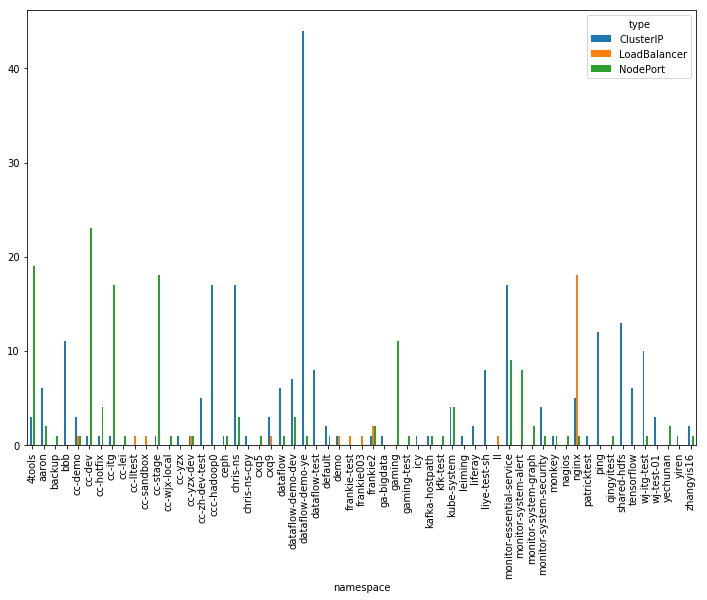

In [21]:
services.groupby(["namespace", "type"]).size().unstack().fillna(0).plot(kind="bar", figsize=(12,8))

## Deployment

### Create pod

In [22]:
from k8sclient.Components import PodBuilder
from k8sclient.keywords import (
    wait_for_pod_state,
    RUNNING,
    delete_pod,
    NOT_FOUND
)

In [ ]:
namespace = "monkey"
image = "127.0.0.1:30100/library/python-tools:v20170619"
args = "loggen.py"
name = "logstress"


def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name,
        image=image,
        args=args,
    ).deploy()
    wait_for_pod_state(namespace, name, 60, RUNNING)


def un_deploy():
    delete_pod(namespace, name)
    wait_for_pod_state(namespace, name, 60, NOT_FOUND)

### Use volumes

In [ ]:
from k8sclient.Components import (
    HostPathVolume, RBDVolume, CephFSVolume, EmptyDirVolume
)
volume_hostpath = HostPathVolume(
        "hostpath-1",
        "/apt/containers",
        "/data/docker/containers"
    )
volume_emptydir = EmptyDirVolume(
    "emptydir-1",
    "/data/something"
)

ceph_monitors = "10.19.137.144:6789,10.19.137.145:6789,10.19.137.146:6789"
ceph_pool = "monkey"
ceph_fstype = "xfs"
ceph_secret = "ceph-secret"
volume_rbd = RBDVolume(
        "rbd",
        "/apt/data",
        fs_type=ceph_fstype,
        image="default",
        pool=ceph_pool,
        monitors=ceph_monitors,
        secret_name=ceph_secret,
        sub_path="writetest",
        read_only=True
    )
volume_cephfs = CephFSVolume(
            "cephfs",
            "/tmp",
            monitors=ceph_monitors,
            secret_name=ceph_secret,
            fs_path="scrapy",
            sub_path="scrapy_name"
        )

def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name,
        image=image,
        args=args,
        volumes=[volume_hostpath, volume_rbd, volume_cephfs, volume_emptydir]
    ).deploy()

### Use service

In [ ]:
from k8sclient.Components import ServicePort, ServiceBuilder

udp_port = ServicePort("dataport", 8125, 8125, protocol="UDP")
http_port = ServicePort("httpport", 80, 80)
udp_service = ServiceBuilder("graphite", namespace).add_port(udp_port)
http_service = ServiceBuilder("graphite-ui", namespace, service_type="NodePort").add_port(http_port)

def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name=name,
        image=image,
        ports=[udp_port, http_port]
    ).attache_service(
        udp_service
    ).attach_service(
        http_service
    ).deploy()

### Env variables

In [ ]:
def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name,
        image=image,
        args=args,
        BATCH_SIZE=10000,
        BATCH_COUNT=1000
    ).deploy()

### Node select

In [ ]:
def deploy():
    PodBuilder(
        name,
        namespace,
    ).set_node(
        node
    ).add_container(
        name,
        image=image,
        args=args,
        BATCH_SIZE=10000,
        BATCH_COUNT=1000
    ).deploy()

### Replicaset example

In [26]:
from k8sclient.Components import ServicePort, ServiceBuilder, ReplicaSetBuilder
# from k8sclient.keywords import wait_for_pod_state, RUNNING

namespace = "k8sft"
name = "graphite"
image = "127.0.0.1:30100/yangtze/graphite-statsd"
# ports
udp_port = ServicePort("dataport", 8125, 8125, protocol="UDP")
http_port = ServicePort("httpport", 80, 80)
# service
udp_service = ServiceBuilder("graphite", namespace).add_port(udp_port)
http_service = ServiceBuilder("graphite-ui", namespace, service_type="NodePort").add_port(http_port)
# replica set
rs = ReplicaSetBuilder(
    name, namespace
).add_container(
    name=name + "-container",
    image=image,
    ports=[udp_port, http_port]
).attache_service(
    http_service
).attache_service(
    udp_service
).set_hostname(name)


def deploy():
    rs.deploy()
    udp_service.deploy()
    http_service.deploy()
    


def un_deploy():
    udp_service.un_deploy()
    http_service.un_deploy()
    rs.un_deploy()

un_deploy()

In [24]:
from k8sclient.dataframes import collect_namespaced_services
s, p, e = collect_namespaced_services("k8sft")
p

,name,node_port,port,protocol,service_id,target_port
0,dataport,None,8125,UDP,a4a5b305-8e19-11e7-93f9-1866da1a2629,8125
1,httpport,30804,80,TCP,a4a7832d-8e19-11e7-93f9-1866da1a2629,80


### switch cluster

In [54]:
from k8sclient.keywords import switch_cluster, register_cluster
register_cluster("yancheng", "~/.kube/config-yancheng")
register_cluster("shanghai", "~/.kube/config-shanghai")
#switch_cluster("yancheng")
switch_cluster("shanghai")